In [3]:
import pandas as pd

gx = pd.read_csv("gyroX.csv")
gy = pd.read_csv("gyroY.csv")
gz = pd.read_csv("gyroZ.csv")

gx.columns = ["timestamp", "gyroX"]
gy.columns = ["timestamp", "gyroY"]
gz.columns = ["timestamp", "gyroZ"]

df = gx.merge(gy, on="timestamp", how="outer").merge(gz, on="timestamp", how="outer")

df = df.sort_values("timestamp")

df = df.ffill()

df.to_csv("imu_gyro_all.csv", index=False)
print("Merged CSV saved with", len(df), "rows")

Merged CSV saved with 19025 rows


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

CSV_IN  = Path("imu_gyro_all.csv")
CSV_OUT = Path("imu_gyro_clean.csv")

df = pd.read_csv(CSV_IN)
df.columns = [c.strip().lower() for c in df.columns]

ts_col = next((c for c in df.columns if "time" in c), "timestamp")
gx_col = next((c for c in df.columns if "gyrox" in c or c=="x"), "gyrox")
gy_col = next((c for c in df.columns if "gyroy" in c or c=="y"), "gyroy")
gz_col = next((c for c in df.columns if "gyroz" in c or c=="z"), "gyroz")

df = df[[ts_col, gx_col, gy_col, gz_col]].rename(
    columns={ts_col:"timestamp", gx_col:"gyroX", gy_col:"gyroY", gz_col:"gyroZ"}
)

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

print(df.head(), "\n\nShape:", df.shape)

                            timestamp      gyroX     gyroY     gyroZ
0 2025-09-27 01:31:21.447830961+00:00  -0.427246  1.708984  0.854492
1 2025-09-27 01:31:22.062103026+00:00 -10.131836 -0.732422 -0.549316
2 2025-09-27 01:31:22.375159113+00:00 -10.375977 -3.417969 -0.671387
3 2025-09-27 01:31:23.192557415+00:00   0.671387 -0.488281  0.122070
4 2025-09-27 01:31:23.507916463+00:00   9.704590 -5.493164 -1.037598 

Shape: (19025, 4)


In [7]:
clean = df.copy()

clean = clean.dropna(how="all", subset=["gyroX","gyroY","gyroZ"])

clean[["gyroX","gyroY","gyroZ"]] = clean[["gyroX","gyroY","gyroZ"]].ffill()

clean[["gyroX","gyroY","gyroZ"]] = clean[["gyroX","gyroY","gyroZ"]].clip(-2000, 2000)

clean = clean.set_index("timestamp").resample("1S").ffill().reset_index()

w = 7
clean["gx_smooth"] = clean["gyroX"].rolling(w, min_periods=1).mean()
clean["gy_smooth"] = clean["gyroY"].rolling(w, min_periods=1).mean()
clean["gz_smooth"] = clean["gyroZ"].rolling(w, min_periods=1).mean()

print("Cleaned rows:", len(clean))
clean.head()

Cleaned rows: 5782


C:\Users\DELL\AppData\Local\Temp\ipykernel_11420\1125064478.py:13: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  clean = clean.set_index("timestamp").resample("1S").ffill().reset_index()


,timestamp,gyroX,gyroY,gyroZ,gx_smooth,gy_smooth,gz_smooth
0,2025-09-27 01:31:21+00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-09-27 01:31:22+00:00,-0.427246,1.708984,0.854492,-0.427246,1.708984,0.854492
2,2025-09-27 01:31:23+00:00,-10.375977,-3.417969,-0.671387,-5.401611,-0.854492,0.091553
3,2025-09-27 01:31:24+00:00,9.704590,-5.493164,-1.037598,-0.366211,-2.400716,-0.284831
4,2025-09-27 01:31:25+00:00,-1.159668,-0.610352,0.732422,-0.564575,-1.953125,-0.030518


In [9]:
clean.to_csv(CSV_OUT, index=False)
print("Clean CSV saved to:", CSV_OUT.resolve())

Clean CSV saved to: C:\Users\DELL\imu_gyro_clean.csv


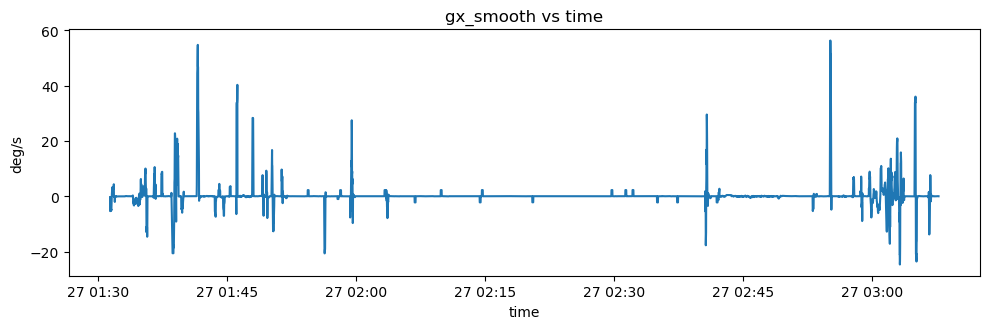

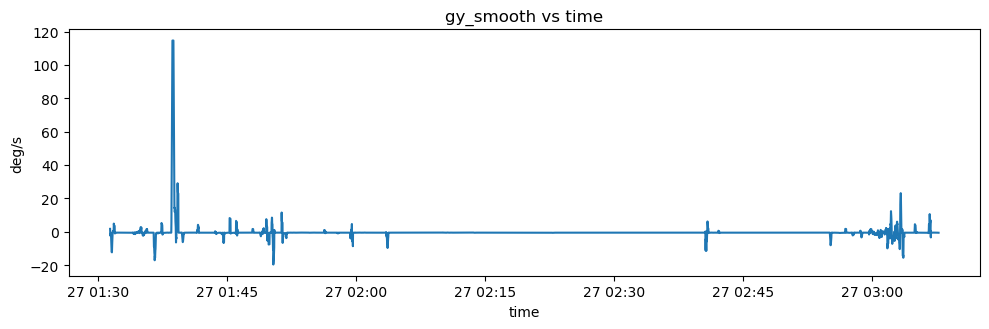

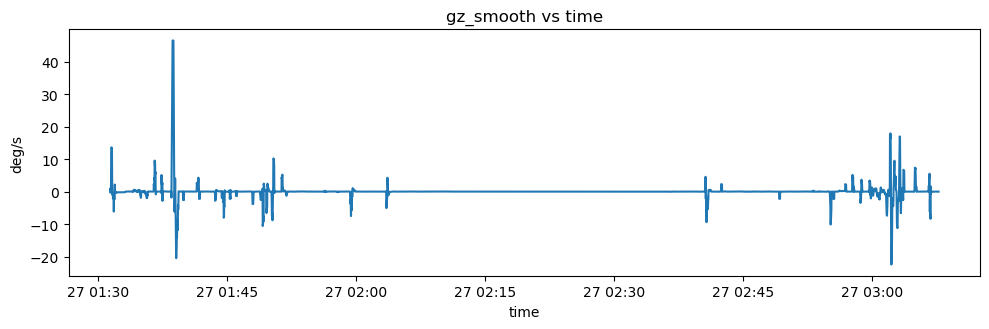

In [11]:
cols_to_plot = ["gx_smooth","gy_smooth","gz_smooth"] if "gx_smooth" in clean.columns else ["gyroX","gyroY","gyroZ"]

for col in cols_to_plot:
    plt.figure(figsize=(10,3.4))
    plt.plot(clean["timestamp"], clean[col])
    plt.title(f"{col} vs time")
    plt.xlabel("time")
    plt.ylabel("deg/s")
    plt.tight_layout()
    plt.show()

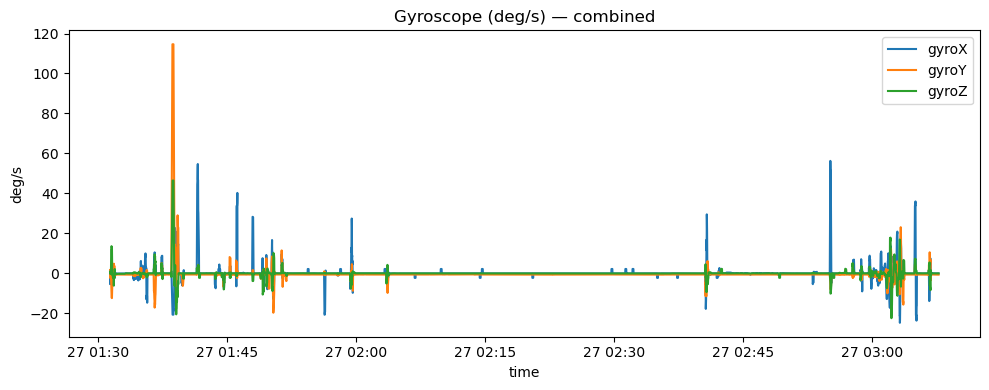

In [13]:
plt.figure(figsize=(10,4))
if "gx_smooth" in clean.columns:
    plt.plot(clean["timestamp"], clean["gx_smooth"], label="gyroX")
    plt.plot(clean["timestamp"], clean["gy_smooth"], label="gyroY")
    plt.plot(clean["timestamp"], clean["gz_smooth"], label="gyroZ")
else:
    plt.plot(clean["timestamp"], clean["gyroX"], label="gyroX")
    plt.plot(clean["timestamp"], clean["gyroY"], label="gyroY")
    plt.plot(clean["timestamp"], clean["gyroZ"], label="gyroZ")

plt.title("Gyroscope (deg/s) — combined")
plt.xlabel("time")
plt.ylabel("deg/s")
plt.legend()
plt.tight_layout()
plt.show()